# **Naive Bayes Model for Predicting Article Section Based on Headlines and Abstracts**

### **DS 5110: Big Data Systems**

### **Spring 2022**

### **Group 1 - New York Times Articles Analysis**

### **Avni Malek (am7bf), Brittany Nguyen (bhn4bf), Cecily Wolfe (cew4pf)**

## **Getting the Data**

### **Set up Directory**

In [1]:
import os
os.getcwd()

'/home/cew4pf'

In [2]:
os.chdir('/project/ds5559/group1_nyt')

In [3]:
os.getcwd()

'/project/ds5559/group1_nyt'

In [4]:
# use to increase driver memory to prevent Java heap space overflow
memory = '20g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [5]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *

spark = SparkSession.builder \
        .appName("test_11") \
        .config("spark.executor.memory", '20g') \
        .getOrCreate()

### **Read in the Preprocessed Data**

In [6]:
df = spark.read.option("header", True).csv('preprocessed_data')

In [7]:
cat_cols = [field for (field, dataType) in df.dtypes if dataType == 'string']

In [8]:
df = df.fillna("", subset = cat_cols)

## **Predict Article Section Based on Headline and Abstract Using a Naive Bayes Model**

In [9]:
# load modules

from pyspark.ml import Pipeline

from pyspark.ml.classification import NaiveBayes

from pyspark.ml.feature import VectorAssembler 

from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StringIndexerModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import StopWordsRemover, CountVectorizer

In [10]:
# load in functions that compute top k accuracy for classification and balance the data with random under/oversampling
from ds5110_proj_funcs import top_k_accuracy, balance_categories

In [11]:
# create transformers and estimator to add to pipeline

# string indexer for sections (assign number to each section)
stringIndexer = StringIndexer(inputCol = 'section', outputCol = 'sectionIndex', handleInvalid = 'skip')

# tokenize abstracts (col with list of words)
tokenizer = Tokenizer(inputCol="combo", outputCol="words")

# remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# count vectorizer to return counts of words that appear in each abstract
countVectors = CountVectorizer(inputCol="filtered", outputCol="features")

# Naive Bayes model to predict section based on words in abstract
nb = NaiveBayes(smoothing = 1.0, modelType="multinomial", labelCol = 'sectionIndex')

# pipeline
nb_pipeline = Pipeline(stages = [stringIndexer, tokenizer, remover, countVectors, nb])

In [12]:
# training, testing split

seed = 42

(train_data, test_data) = df.randomSplit([0.8, 0.2], seed = seed)

In [13]:
# create model
nb_model = nb_pipeline.fit(train_data)

In [14]:
# make predictions
nb_preds = nb_model.transform(test_data)

In [15]:
# evaluate model on test data
ev = MulticlassClassificationEvaluator(labelCol = 'sectionIndex', predictionCol="prediction")

# f1
f1 = ev.evaluate(nb_preds)

# log loss
log_loss = ev.evaluate(nb_preds, {ev.metricName: "logLoss"})

# accuracy
accuracy = ev.evaluate(nb_preds, {ev.metricName: "accuracy"})

print("f1:", f1, "\nlog_loss:", log_loss, "\naccuracy:", accuracy)

f1: 0.46238562897312857 
log_loss: 3.5979969110400085 
accuracy: 0.5045454545454545


In [16]:
# training accuracy
train_nb = nb_model.transform(train_data)

ev.evaluate(train_nb, {ev.metricName: "accuracy"})

0.8253744624054575

In [17]:
# from pyspark.sql.functions: monotonically_increasing_id, array, arrays_zip, explode, lit, rank, col
from pyspark.ml.functions import vector_to_array
from pyspark.sql.window import Window

### **Top K Accuracy**

In [18]:
# compute top k = 5 accuracy for predictions (i.e., correct section in the 5 classes with the highest probability)
top_4_accuracy = top_k_accuracy(nb_preds, 'section', 4)
top_4_accuracy

0.7642424242424243

In [19]:
# compute top k = 5 accuracy for predictions (i.e., correct section in the 5 classes with the highest probability)
top_5_accuracy = top_k_accuracy(nb_preds, 'section', 5)
top_5_accuracy

0.8018181818181818

### **Attempt to fit the model with the `new_section` column instead (with label "Other" that combines sections with < 100 articles into one section)**

In [20]:
# new StringIndexer instance using the new_section column
stringIndexer_2 = StringIndexer(inputCol = 'new_section', outputCol = 'sectionIndex')

In [21]:
nb_pipeline_2 = Pipeline(stages = [stringIndexer_2, tokenizer, remover, countVectors, nb])

In [22]:
nb_model_2 = nb_pipeline_2.fit(train_data)

In [23]:
nb_preds_2 = nb_model_2.transform(test_data)

In [24]:
# f1
f1_2 = ev.evaluate(nb_preds_2)

# log loss
log_loss_2 = ev.evaluate(nb_preds_2, {ev.metricName: "logLoss"})

# accuracy
accuracy_2 = ev.evaluate(nb_preds_2, {ev.metricName: "accuracy"})

print("f1:", f1_2, "\nlog_loss:", log_loss_2, "\naccuracy:", accuracy_2)

f1: 0.4620147722110618 
log_loss: 3.451324994957639 
accuracy: 0.5040896697970312


#### **Create A Balanced Dataset to (Potentially) Improve Accuracy $\rightarrow$ Due to Highly Imbalanced Number of Articles Per Section**

In [25]:
import numpy as np

In [26]:
# balance the data (see ds5100_proj_funcs.py for more information) --> each section sampled so ~ mean num of articles in each
balanced_data = balance_categories(df, "new_section")

In [27]:
balanced_data.groupby('new_section').count().sort('count', ascending = False).show(26)

+--------------------+-----+
|         new_section|count|
+--------------------+-----+
|             Theater|  678|
|               World|  673|
|                Arts|  669|
|             Opinion|  666|
|        Business Day|  666|
|              Health|  659|
|          Technology|  655|
|                U.S.|  654|
|              Travel|  654|
|            Magazine|  653|
|                Food|  653|
|              Sports|  652|
|               Style|  652|
|               Books|  649|
|  Crosswords & Games|  646|
|              Movies|  645|
|               Other|  642|
|            New York|  642|
|       Times Insider|  639|
|                Well|  638|
|         Real Estate|  635|
|             Climate|  634|
|The Learning Network|  633|
|             Science|  633|
|            Podcasts|  628|
|          The Upshot|  622|
+--------------------+-----+



In [28]:
# generate balanced training and testing datasets

seed = 42

(train_balanced, test_balanced) = balanced_data.randomSplit([0.8, 0.2], seed = seed)

In [29]:
nb_model_3 = nb_pipeline_2.fit(train_balanced)

In [30]:
nb_preds_3 = nb_model_3.transform(test_balanced)

In [31]:
# f1
f1_3 = ev.evaluate(nb_preds_3, {ev.metricName: "logLoss"})

# log loss
log_loss_3 = ev.evaluate(nb_preds_3, {ev.metricName: "logLoss"})

# accuracy
accuracy_3 = ev.evaluate(nb_preds_3, {ev.metricName: "accuracy"})

print("f1:", f1_3, "\nlog_loss:", log_loss_3, "\naccuracy:", accuracy_3)

f1: 0.8405172213679609 
log_loss: 0.8405172213679609 
accuracy: 0.820431654676259


In [32]:
# top k accuracy, k = 2
top_2_balanced = top_k_accuracy(nb_preds_3, 'section', 2)

top_2_balanced

0.88

In [33]:
# top k accuracy, k = 5
top_5_balanced = top_k_accuracy(nb_preds_3, 'section', 5)

top_5_balanced

0.941294964028777

### **Cross Validation**

In [34]:
# regenerate the balanced training and test sets without the columns with predictions and probabilites

seed = 42

(train_balanced, test_balanced) = balanced_data.randomSplit([0.8, 0.2], seed = seed)

In [35]:
# build a grid of parameters --> different vocab size for CountVectorizer, different smoothing (alpha) values for Naive Bayes
paramGrid = ParamGridBuilder() \
    .addGrid(countVectors.vocabSize, [100000, 500000, 1000000]) \
    .addGrid(nb.smoothing, [1.0, 5.0, 10.0, 15.0, 20.0]) \
    .build()

# number of parameter combinations tested (3 x 5 = 15)
print('len(paramGrid): {}'.format(len(paramGrid)))

# CrossValidator instance with nb_pipeline as the estimator
crossval = CrossValidator(estimator=nb_pipeline_2,
                          estimatorParamMaps=paramGrid,
                          evaluator=ev,
                          numFolds=3,
                          seed = seed)

# Cross validation model that returns the best set of parameters
import time
t0 = time.time()
cvModel = crossval.setParallelism(8).fit(train_balanced)
print("train time:", time.time() - t0)

len(paramGrid): 15
train time: 74.00507640838623


In [36]:
# average metrics across three models fit for a given combination of params (since three folds)
avg_metrics = cvModel.avgMetrics

# largest metric
max_metric = np.max(avg_metrics)

# max metric and location in list
print("average metrics:", avg_metrics, "\n\nmax metric and position: {}, {}".format(max_metric, np.argmax(max_metric)))

average metrics: [0.7489670650390068, 0.7007223718735018, 0.6657686565727949, 0.6429986819262679, 0.6246259117145407, 0.7489670650390068, 0.7007223718735018, 0.6657686565727949, 0.6429986819262679, 0.6246259117145407, 0.7489670650390068, 0.7007223718735018, 0.6657686565727949, 0.6429986819262679, 0.6246259117145407] 

max metric and position: 0.7489670650390068, 0


In [37]:
# combine average metrics and paramGrid (in same order)
metrics_and_params = list(zip(cvModel.avgMetrics, paramGrid))

# pull out best param combination (the one in cvModel)
best_params = metrics_and_params[np.argmax(avg_metrics)][1].values()
best_params

dict_values([100000, 1.0])

In [38]:
# performance on training data
ev.evaluate(cvModel.transform(train_balanced), {ev.metricName: "accuracy"})

0.9755879059350504

In [39]:
# preds on test data
predictions = cvModel.transform(test_balanced)

In [40]:
predictions.select('new_section', 'sectionIndex', 'probability', 'prediction').show()

+-----------+------------+--------------------+----------+
|new_section|sectionIndex|         probability|prediction|
+-----------+------------+--------------------+----------+
|       Well|         8.0|[1.49740534706059...|       8.0|
|       Well|         8.0|[1.14619319515903...|       8.0|
|       Well|         8.0|[1.55999807473589...|       8.0|
|       Well|         8.0|[2.16776779347742...|       8.0|
|       Well|         8.0|[1.46848971676707...|       8.0|
|       Well|         8.0|[2.06309112930398...|       8.0|
|       Well|         8.0|[4.37428403093914...|       8.0|
|       Well|         8.0|[3.92898962367386...|       8.0|
|       Well|         8.0|[1.48366400807146...|       8.0|
|       Well|         8.0|[0.00132688578449...|       2.0|
|       Well|         8.0|[0.00132688578449...|       2.0|
|       Well|         8.0|[3.47987707560461...|       8.0|
|       Well|         8.0|[3.75874861654058...|       2.0|
|       Well|         8.0|[1.46338978579512...|       8.

In [41]:
# f1
f1_crossval = ev.evaluate(predictions)

# log loss
log_loss_crossval = ev.evaluate(predictions, {ev.metricName: "logLoss"})

# accuracy
accuracy_crossval = ev.evaluate(predictions, {ev.metricName: "accuracy"})

print("f1:", f1_crossval, "\nlog_loss:", log_loss_crossval, "\naccuracy:", accuracy_crossval)

f1: 0.8153030293806836 
log_loss: 0.8405172213679609 
accuracy: 0.820431654676259


In [42]:
# top k accuracy, k = 2
top_2_balanced = top_k_accuracy(predictions, 'section', 2)

top_2_balanced

0.88

In [43]:
# top k accuracy, k = 5
top_5_balanced = top_k_accuracy(predictions, 'section', 5)

top_5_balanced

0.941294964028777

### **Examine Misclassifications**

In [44]:
# dataframe that acts as a key for section and index
section_labels = predictions.select('new_section', 'sectionIndex').distinct().sort('sectionIndex')

section_labels = section_labels.withColumnRenamed('new_section', 'predicted_section') \
                               .withColumnRenamed('sectionIndex', 'label')

section_labels.show(30)

+--------------------+-----+
|   predicted_section|label|
+--------------------+-----+
|        Business Day|  0.0|
|              Travel|  1.0|
|              Health|  2.0|
|             Theater|  3.0|
|             Opinion|  4.0|
|                Arts|  5.0|
|               Other|  6.0|
|               Style|  7.0|
|                Well|  8.0|
|            Magazine|  9.0|
|              Sports| 10.0|
|               World| 11.0|
|         Real Estate| 12.0|
|          Technology| 13.0|
|                U.S.| 14.0|
|                Food| 15.0|
|       Times Insider| 16.0|
|            New York| 17.0|
|              Movies| 18.0|
|The Learning Network| 19.0|
|          The Upshot| 20.0|
|               Books| 21.0|
|            Podcasts| 22.0|
|  Crosswords & Games| 23.0|
|             Science| 24.0|
|             Climate| 25.0|
+--------------------+-----+



In [45]:
# join predictions with section_labels to get predicted section name
true_pred_sections = predictions.join(section_labels, predictions.prediction == section_labels.label) \
                                .select('new_section', 'sectionIndex', 'prediction', 'predicted_section')

true_pred_sections.show()

+-----------+------------+----------+-----------------+
|new_section|sectionIndex|prediction|predicted_section|
+-----------+------------+----------+-----------------+
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|             Well|
|       Well|         8.0|       8.0|           

In [46]:
# filter to keep only the misclassified articles
misclassified = true_pred_sections.filter(true_pred_sections.new_section != true_pred_sections.predicted_section)

In [47]:
# most commonly misclassified sections
misclassified.groupby('new_section').count().sort('count', ascending = False).show()

+--------------------+-----+
|         new_section|count|
+--------------------+-----+
|             Opinion|   98|
|                U.S.|   56|
|               World|   43|
|                Arts|   41|
|            Magazine|   38|
|        Business Day|   37|
|            Podcasts|   36|
|               Style|   36|
|            New York|   32|
|                Well|   30|
|               Other|   29|
|          The Upshot|   24|
|The Learning Network|   19|
|         Real Estate|   16|
|               Books|   15|
|                Food|   15|
|             Science|   13|
|  Crosswords & Games|   10|
|          Technology|   10|
|              Sports|    7|
+--------------------+-----+
only showing top 20 rows



In [48]:
# most common misclassification errors
misclassified.groupby(misclassified.columns).count().sort('count', ascending = False).show()

+------------+------------+----------+-----------------+-----+
| new_section|sectionIndex|prediction|predicted_section|count|
+------------+------------+----------+-----------------+-----+
|     Opinion|         4.0|      14.0|             U.S.|   33|
|        Well|         8.0|       2.0|           Health|   11|
|     Opinion|         4.0|      20.0|       The Upshot|   10|
|     Opinion|         4.0|       2.0|           Health|   10|
|       World|        11.0|       2.0|           Health|    9|
|        U.S.|        14.0|      20.0|       The Upshot|    8|
|       World|        11.0|      14.0|             U.S.|    8|
|        U.S.|        14.0|       2.0|           Health|    8|
|        U.S.|        14.0|      11.0|            World|    8|
|        U.S.|        14.0|      17.0|         New York|    8|
|Business Day|         0.0|      13.0|       Technology|    7|
|        Arts|         5.0|      18.0|           Movies|    7|
|       Style|         7.0|       8.0|             Well

In [49]:
# most common misclassification errors by section
misclassified.groupby(misclassified.columns).count().sort('new_section', 'count', ascending = False).show(30)

+-----------+------------+----------+--------------------+-----+
|new_section|sectionIndex|prediction|   predicted_section|count|
+-----------+------------+----------+--------------------+-----+
|      World|        11.0|       2.0|              Health|    9|
|      World|        11.0|      14.0|                U.S.|    8|
|      World|        11.0|       9.0|            Magazine|    4|
|      World|        11.0|       0.0|        Business Day|    4|
|      World|        11.0|      17.0|            New York|    4|
|      World|        11.0|      25.0|             Climate|    3|
|      World|        11.0|      21.0|               Books|    2|
|      World|        11.0|       5.0|                Arts|    1|
|      World|        11.0|       8.0|                Well|    1|
|      World|        11.0|       1.0|              Travel|    1|
|      World|        11.0|      16.0|       Times Insider|    1|
|      World|        11.0|      18.0|              Movies|    1|
|      World|        11.0

In [50]:
# number of different sections incorrectly predicted for each section
misclassified.groupby('new_section').agg(countDistinct('predicted_section').alias('section_pred_count')) \
                                    .sort('section_pred_count', ascending = False).show()

+--------------------+------------------+
|         new_section|section_pred_count|
+--------------------+------------------+
|             Opinion|                20|
|            Magazine|                19|
|                U.S.|                17|
|               Style|                16|
|               World|                16|
|                Arts|                16|
|        Business Day|                15|
|            Podcasts|                15|
|               Other|                13|
|                Well|                12|
|            New York|                12|
|The Learning Network|                12|
|               Books|                11|
|          The Upshot|                10|
|                Food|                 9|
|  Crosswords & Games|                 9|
|         Real Estate|                 7|
|             Science|                 6|
|              Sports|                 6|
|          Technology|                 6|
+--------------------+------------

In [51]:
# number of misclassified articles by section
misclass_nums = misclassified.groupby('new_section').count().sort('count', ascending = False)

In [52]:
# number of articles in test set by section
preds_nums = predictions.groupby('new_section').count().sort('count', asceinding = False) \
                        .withColumnRenamed('new_section', 'preds_section') \
                        .withColumnRenamed('count', 'total_count')

In [53]:
# join to get misclassified and total counts for each section
misclass_percents = misclass_nums.join(preds_nums, misclass_nums.new_section == preds_nums.preds_section, "inner").drop('preds_section')

# get percentage of misclassified articles per section
misclass_percents = misclass_percents.withColumn('misclass_percent', misclass_percents['count'] / misclass_percents.total_count * 100) \
                                     .sort('misclass_percent', ascending = False)

misclass_percents.show()

+--------------------+-----+-----------+------------------+
|         new_section|count|total_count|  misclass_percent|
+--------------------+-----+-----------+------------------+
|             Opinion|   98|        140|              70.0|
|                U.S.|   56|        139| 40.28776978417266|
|            Magazine|   38|        131| 29.00763358778626|
|                Arts|   41|        145| 28.27586206896552|
|        Business Day|   37|        131| 28.24427480916031|
|               Style|   36|        128|            28.125|
|            Podcasts|   36|        129|27.906976744186046|
|               World|   43|        155|27.741935483870968|
|                Well|   30|        115| 26.08695652173913|
|               Other|   29|        118|24.576271186440678|
|            New York|   32|        131|24.427480916030532|
|          The Upshot|   24|        117| 20.51282051282051|
|The Learning Network|   19|        128|          14.84375|
|         Real Estate|   16|        119|

In [54]:
# convert to dataframe for plotting
class_nums = misclass_percents.toPandas()

class_nums

new_section  count  total_count  misclass_percent
0                Opinion     98          140         70.000000
1                   U.S.     56          139         40.287770
2               Magazine     38          131         29.007634
3                   Arts     41          145         28.275862
4           Business Day     37          131         28.244275
5                  Style     36          128         28.125000
6               Podcasts     36          129         27.906977
7                  World     43          155         27.741935
8                   Well     30          115         26.086957
9                  Other     29          118         24.576271
10              New York     32          131         24.427481
11            The Upshot     24          117         20.512821
12  The Learning Network     19          128         14.843750
13           Real Estate     16          119         13.445378
14                  Food     15          139         10.791367
15                 Books     15          145         10.344828
16               Science     13          136          9.558824
17            Technology     10          139          7.194245
18    Crosswords & Games     10          149          6.711409
19                Health      7          131          5.343511
20                Sports      7          133          5.263158
21                Travel      4          123          3.252033
22               Theater      4          150          2.666667
23                Movies      2          135          1.481481
24               Climate      2          142          1.408451

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt

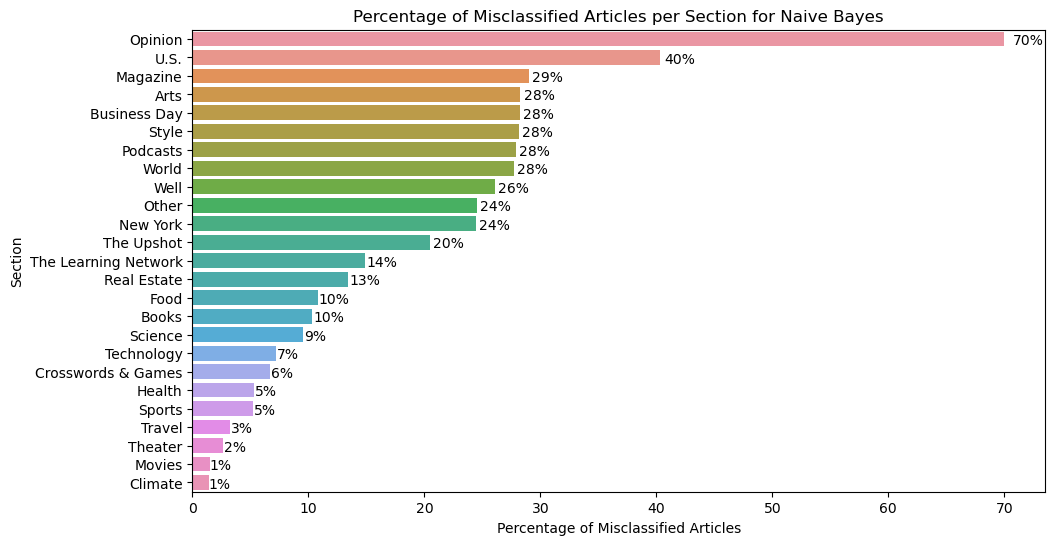

In [56]:
## code from Dr. Jonathan Kropko, University of Virginia School of Data Science; Surfing the Data Pipeline Ch. 11: Visualizations

plt.figure(figsize=(11, 6))
myplot = sns.barplot(x='misclass_percent', y='new_section', data = class_nums)
plt.ylabel('Section')
plt.xlabel('Percentage of Misclassified Articles')
plt.title('Percentage of Misclassified Articles per Section for Naive Bayes')
for rect in myplot.patches:
    ycoor = rect.get_y() + .6*rect.get_height()
    xcoor = 1.01*rect.get_width()
    plt.text(xcoor, ycoor, str(int(xcoor)) + "%", 
             horizontalalignment='left', 
             verticalalignment='center',
             fontsize=10)

plt.show()

plt.close()

In [57]:
misclass_groups = misclassified.groupby('new_section').agg(countDistinct('predicted_section').alias('section_pred_count')) \
                               .sort('section_pred_count', ascending = False) \
                               .toPandas()

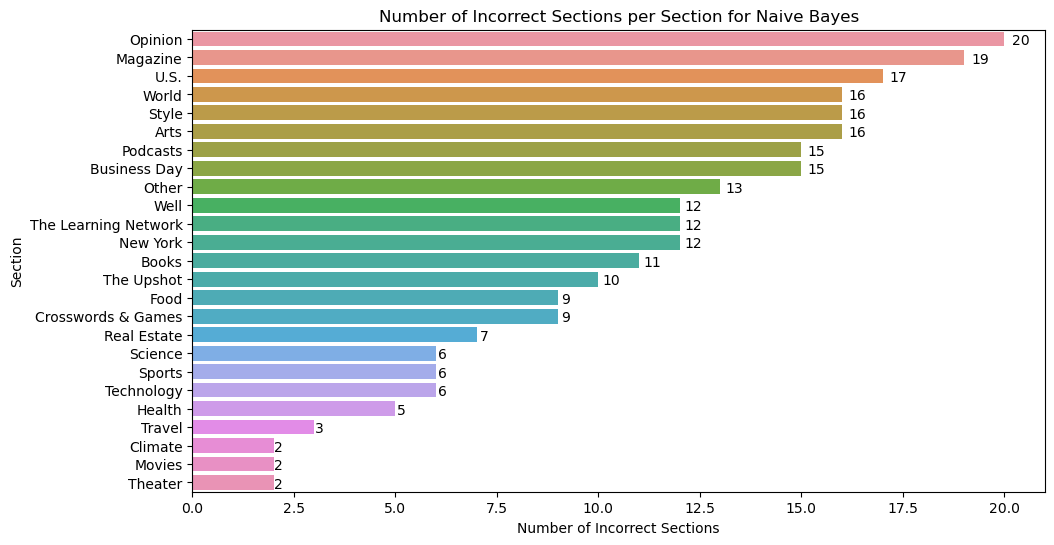

In [58]:
## code from Dr. Jonathan Kropko, University of Virginia School of Data Science; Surfing the Data Pipeline Ch. 11: Visualizations

plt.figure(figsize=(11, 6))
myplot = sns.barplot(x='section_pred_count', y='new_section', data = misclass_groups)
plt.ylabel('Section')
plt.xlabel('Number of Incorrect Sections')
plt.title('Number of Incorrect Sections per Section for Naive Bayes')
for rect in myplot.patches:
    ycoor = rect.get_y() + .6*rect.get_height()
    xcoor = 1.01*rect.get_width()
    plt.text(xcoor, ycoor, str(int(xcoor)), 
             horizontalalignment='left', 
             verticalalignment='center',
             fontsize=10)

plt.show()

plt.close()

#### **Sources**

* Read a CSV file into Spark: https://sparkbyexamples.com/pyspark/pyspark-read-csv-file-into-dataframe/
* Convert columns to different data type with `withColumn` and `df.col1.cast("dtype")`: https://sparkbyexamples.com/pyspark/pyspark-cast-column-type/
* Check for missing values: from `data_preprocessing.ipydt` in `assingments/M4_3_data_preprocs_ungraded`)
* Extract single values from a dataframe in pyspark: https://www.geeksforgeeks.org/pyspark-extracting-single-value-from-dataframe/
* Drop multiple columns with `*`: https://sparkbyexamples.com/pyspark/pyspark-drop-column-from-dataframe/
* Argument `subset` for subset of columns when replacing null values with `df.fillna`: https://sparkbyexamples.com/pyspark/pyspark-fillna-fill-replace-null-values/
* Calculating percentage of total count for groupBy using pyspark: https://stackoverflow.com/questions/52283751/calculating-percentage-of-total-count-for-groupby-using-pyspark
* Spark Dataframe: How to add an index Column with `monotonically_increasing_id`: https://stackoverflow.com/questions/43406887/spark-dataframe-how-to-add-a-index-column-aka-distributed-data-index
* Classification and Regression in Spark: https://spark.apache.org/docs/latest/ml-classification-regression.html
* Multi-Class Text Classification with PySpark $\rightarrow$ for using `CountVectorizer`: https://towardsdatascience.com/multi-class-text-classification-with-pyspark-7d78d022ed35
* `CountVectorizer` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html#pyspark.ml.feature.CountVectorizer.minDF
* PySpark: modify column values when another column value satisfies a condition with `when` and `otherwise` from `pyspark.sql.functions`: https://stackoverflow.com/questions/43988801/pyspark-modify-column-values-when-another-column-value-satisfies-a-condition
* Get value of a particular cell in PySpark Dataframe: https://www.geeksforgeeks.org/get-value-of-a-particular-cell-in-pyspark-dataframe/
* Using a fraction > 1.0 for up-sampling data: https://stackoverflow.com/questions/53273133/how-to-perform-up-sampling-using-sample-functionpy-spark
* Append data to an empty dataframe in PySpark: https://www.geeksforgeeks.org/append-data-to-an-empty-dataframe-in-pyspark/
* `pyspark.sql.functions.explode` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.explode.html
* `pyspark.sql.functions.arrays_zip` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.arrays_zip.html
* Retrieve top n in each group of a DataFrame in pyspark: https://stackoverflow.com/questions/38397796/retrieve-top-n-in-each-group-of-a-dataframe-in-pyspark
* Introducing Window Functions in Spark SQL: https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html
* Convert PySpark DenseVector to array: https://stackoverflow.com/questions/58490770/convert-pyspark-densevector-to-array
* Aggregate function `collect_list`: https://sparkbyexamples.com/pyspark/pyspark-aggregate-functions/
* pyspark `collect_set` or `collect_list` with `groupby`: https://stackoverflow.com/questions/37580782/pyspark-collect-set-or-collect-list-with-groupby
* PySpark Join Types: https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/
* Removing duplicate columns after join in PySpark by specificying duplicate column in join function with argument `['col1']`: https://www.geeksforgeeks.org/removing-duplicate-columns-after-dataframe-join-in-pyspark/#:~:text=Removing%20duplicate%20columns%20after%20join,and%20then%20drop%20duplicate%20columns
* Count categories in another column after `groupby` with `.agg(countDistict('col1'))`: https://stackoverflow.com/questions/46421677/how-to-count-unique-id-after-groupby-in-pyspark
* Checking dataframe equality with `df1.subtract(df2)`: https://community.databricks.com/s/question/0D53f00001HKHZeCAP/comparing-two-dataframes
* Cross validation in pyspark: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html?highlight=crossvalidator
* Get (default) metric of `MulticlassMetrics` evaluator with `getMetricName()` method: https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/ml/evaluation/MulticlassClassificationEvaluator.html
* Increasing driver memory in Jupyter: https://stackoverflow.com/questions/51601478/setting-pyspark-executor-memory-and-executor-core-within-jupyter-notebook
* Getting the best parameter combination from cross validation using `zip` with `.avgMetrics` and `paramGrid`: https://community.databricks.com/s/question/0D53f00001HKHh5CAH/pyspark-how-to-get-best-params-in-grid-search
* Visualizations (bar graphs) code: https://jkropko.github.io/surfing-the-data-pipeline/ch11.html#distributional-graphs
* Nested list comprehensions: https://www.geeksforgeeks.org/nested-list-comprehensions-in-python/
* Remove a legend from a plot in `seaborn`: https://www.delftstack.com/howto/seaborn/remove-legend-seaborn-plot/
* Get the value in a particular row and column in Spark: https://www.geeksforgeeks.org/get-value-of-a-particular-cell-in-pyspark-dataframe/
* `15. ML Model Selection and Tuning.ipynb`
* `11. ML Pipelines.ipynb`
* `10. ML Feature Utilities.ipynb`
* `12. MLlib Regression.ipynb`
* `08. MLlib Statistics.ipynb`
* `09. MLlib Classification.ipynb`
* `07. Machine Learning with MLlib - Overview.ipynb`
* `05. SparkSession, Spark SQL and DataFrames.ipynb`
* `04. Running Spark on a Cluster.ipynb`
* `03. KeyValuePairs.ipynb`
* `02. RDDs.ipynb`
* `01. SparkGettingStarted.ipynb`